In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import re

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


In [2]:
List_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(List_url).text

In [3]:
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')
#dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)
# Search all the postcode, borough, neighborhood 
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [4]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [5]:
df=df[df['Borough']!='Not assigned']
temp_df=df.groupby('Postalcode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)
df_merge = pd.merge(df, temp_df, on='Postalcode')
df_merge.drop(['Neighborhood'],axis=1,inplace=True)
df_merge.drop_duplicates(inplace=True)
df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'},inplace=True)
df_merge.head(15)

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,Malvern / Rouge
7,M3B,North York,Don Mills
8,M4B,East York,Parkview Hill / Woodbine Gardens
9,M5B,Downtown Toronto,"Garden District, Ryerson"


<h3>Utilizing the Geospatial location data,to get the latitude and the longitude coordinates of each neighborhood</h3>

In [6]:
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
geo_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
geo_merged = pd.merge(geo_df, df_merge, on='Postalcode')
geo_data=geo_merged[['Postalcode','Borough','Neighborhood','Latitude','Longitude']]

In [8]:
geo_data.head(15)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park,43.727929,-79.262029
7,M1L,Scarborough,Golden Mile / Clairlea / Oakridge,43.711112,-79.284577
8,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West,43.716316,-79.239476
9,M1N,Scarborough,Birch Cliff / Cliffside West,43.692657,-79.264848


<h3>Utilizing the Foursquare location data,to get the latitude and the longitude coordinates of venues in each neighborhood</h3>

In [9]:
CLIENT_ID = 'B0N5SQ0RVOSFNCE1ZY31VH0ZGMYQWWSG45HT3FNTHTI1SMAF' # your Foursquare ID
CLIENT_SECRET = '5W5DKOMIGJUGRX43CCSY1KNALIB2MUNJ1AP0C313QFTM5TFX' # your Foursquare Secret
VERSION = '20180604'

In [10]:
# FourSquare parameters
radius = 1000 # 1 km around the neighborhood center
limit = 200

venues = []

for lat, long, neighborhood in zip(geo_data['Latitude'], geo_data['Longitude'], geo_data['Postalcode']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [11]:
# put the venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Postalcode', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']

# check the dataframe
print(venues_df.shape)
print('There are {} unique venue types.'.format(len(venues_df['VenueType'].unique())))
venues_df.head()

(4908, 7)
There are 328 unique venue types.


,Postalcode,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueType
0,M1B,43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
1,M1B,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
2,M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
3,M1B,43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant
4,M1B,43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store


In [12]:
# one hot encoding
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")

# add the neighborhood column
venues_type_onehot['Postalcode'] = venues_df['Postalcode']
fix_columns = list(venues_type_onehot.columns[-1:]) + list(venues_type_onehot.columns[:-1])
venues_type_onehot = venues_type_onehot[fix_columns]

print(venues_type_onehot.shape)
venues_type_onehot.head()

(4908, 329)


,Postalcode,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:

# get the occurrence of each venue type in each neighborhood
venue_count_df = venues_type_onehot.groupby(['Postalcode']).sum().reset_index()

print(venue_count_df.shape)
venue_count_df.head()

(102, 329)


,Postalcode,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1H,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


<h4 align=left>Fetching Number of Elementary Schools in GTA per neighborhood</h4>

In [14]:
elementary_schools_url = 'https://www.tdsb.on.ca/Find-your/School/Elementary'
source2 = requests.get(elementary_schools_url).text
soup2 = BeautifulSoup(source2, 'xml')
data=soup2.find_all(string=re.compile(", ON, M*"))

df_elementary = pd.DataFrame (data,columns = ["FullAddress"])
df_elementary_new = pd.DataFrame (columns = ['Address','Neighborhood','Province','Postalcode'])
df_elementary_new = df_elementary_new.replace(r'\\n',' ', regex=True) 
df_elementary=df_elementary.FullAddress.str.split(",",expand=True)

df_elementary_new["Address"]= df_elementary[0] 
df_elementary_new["Neighborhood"]= df_elementary[1] 
df_elementary_new["Province"]= df_elementary[2] 
df_elementary_new["Postalcode"]= df_elementary[3] 
df_elementary_new = df_elementary_new.drop('Address', 1)
df_elementary_new = df_elementary_new.drop('Province', 1)

df_elementary_new['Postalcode'] = df_elementary_new['Postalcode'].str[:4]


value_counts_elementary = df_elementary_new['Postalcode'].value_counts(dropna=True, sort=True)
df_val_counts_elementary = pd.DataFrame(value_counts_elementary)
df_val_counts_elementary = df_val_counts_elementary.reset_index()
df_val_counts_elementary.columns = ['Postalcode', 'counts']
df_val_counts_elementary.head()

,Postalcode,counts
0,M1B,16
1,M2J,13
2,M1E,12
3,M1W,11
4,M3N,10


In [15]:
intermediate_schools_url = 'https://www.tdsb.on.ca/Find-your/School/Intermediate'
source3 = requests.get(intermediate_schools_url).text
soup3 = BeautifulSoup(source3, 'xml')
data=soup3.find_all(string=re.compile(", ON, M*"))

df_intermediate = pd.DataFrame (data,columns = ["FullAddress"])
df_intermediate_new = pd.DataFrame (columns = ['Address','Neighborhood','Province','Postalcode'])
df_intermediate = df_intermediate.replace(r'\\n',' ', regex=True) 
df_intermediate=df_intermediate.FullAddress.str.split(",",expand=True)

df_intermediate_new["Address"]= df_intermediate[0] 
df_intermediate_new["Neighborhood"]= df_intermediate[1] 
df_intermediate_new["Province"]= df_intermediate[2] 
df_intermediate_new["Postalcode"]= df_intermediate[3] 
df_intermediate_new = df_intermediate_new.drop('Address', 1)
df_intermediate_new = df_intermediate_new.drop('Province', 1)
df_intermediate_new['Postalcode'] = df_intermediate_new['Postalcode'].str[:4]



value_counts_intermediate = df_intermediate_new['Postalcode'].value_counts(dropna=True, sort=True)
df_val_counts_intermediate = pd.DataFrame(value_counts_intermediate)
df_val_counts_intermediate = df_val_counts_intermediate.reset_index()
df_val_counts_intermediate.columns = ['Postalcode', 'counts']
df_val_counts_intermediate.head()


,Postalcode,counts
0,M1B,11
1,M1E,9
2,M1V,7
3,M1L,6
4,M9V,6


In [16]:
secondary_schools_url = 'https://www.tdsb.on.ca/Find-your/School/Secondary'
source4 = requests.get(secondary_schools_url).text
soup4 = BeautifulSoup(source4, 'xml')
data=soup4.find_all(string=re.compile(", ON, M*"))

df_secondary = pd.DataFrame (data,columns = ["FullAddress"])
df_secondary_new = pd.DataFrame (columns = ['Address','Neighborhood','Province','Postalcode'])
df_secondary_count=pd.DataFrame (columns = ['Counts'])
df_secondary_new_count=pd.DataFrame (columns = ['Postalcode','Counts'])
df_secondary = df_secondary.replace(r'\\n',' ', regex=True) 
df_secondary=df_secondary.FullAddress.str.split(",",expand=True)

df_secondary_new["Address"]= df_secondary[0] 
df_secondary_new["Neighborhood"]= df_secondary[1] 
df_secondary_new["Province"]= df_secondary[2] 
df_secondary_new["Postalcode"]= df_secondary[3] 
df_secondary_new = df_secondary_new.drop('Address', 1)
df_secondary_new = df_secondary_new.drop('Province', 1)

df_secondary_new['Postalcode'] = df_secondary_new['Postalcode'].str[:4]

value_counts_secondary= df_secondary_new['Postalcode'].value_counts(dropna=True, sort=True)
df_val_counts_secondary = pd.DataFrame(value_counts_secondary)
df_val_counts_secondary = df_val_counts_secondary.reset_index()
df_val_counts_secondary.columns = ['Postalcode', 'counts']
df_val_counts_secondary.head()

,Postalcode,counts
0,M4J,5
1,M6P,4
2,M1E,4
3,ON,4
4,M2M,3


In [17]:
df_schools_temp = pd.concat([df_val_counts_secondary, df_val_counts_intermediate])\
       .groupby('Postalcode')['counts']\
       .sum().reset_index()
df_schools = pd.concat([df_schools_temp, df_val_counts_elementary])\
       .groupby('Postalcode')['counts']\
       .sum().reset_index()

In [18]:
df_schools.head()

,Postalcode,counts
0,M1B,28
1,M1C,13
2,M1E,25
3,M1G,16
4,M1H,6


<h4 align=left>Fetching Foursquare location data of GTA per neighborhood</h4>

In [19]:
geo_schools_df=pd.read_csv('http://cocl.us/Geospatial_data')
geo_schools_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [20]:
geo_schools_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
geo_merged_schools = pd.DataFrame (columns = ['Postalcode','Latitude','Longitude','counts'])
geo_schools_df.dropna()
df_schools.dropna()
df_schools.head()

,Postalcode,counts
0,M1B,28
1,M1C,13
2,M1E,25
3,M1G,16
4,M1H,6


In [21]:
df_schools.Postalcode = df_schools.Postalcode.astype(str)
geo_schools_df.Postalcode= geo_schools_df.Postalcode.astype(str)
df_schools.Postalcode = df_schools.Postalcode.str.strip()
df_schools.head()

,Postalcode,counts
0,M1B,28
1,M1C,13
2,M1E,25
3,M1G,16
4,M1H,6


In [22]:
geo_schools_df.Postalcode = geo_schools_df.Postalcode.str.strip()
geo_schools_df.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [23]:
geo_merged_schools = pd.merge(geo_schools_df, df_schools, how='inner',on='Postalcode')
geo_merged_schools.head()

,Postalcode,Latitude,Longitude,counts
0,M1B,43.806686,-79.194353,28
1,M1C,43.784535,-79.160497,13
2,M1E,43.763573,-79.188711,25
3,M1G,43.770992,-79.216917,16
4,M1H,43.773136,-79.239476,6


<h4 align=left>Fetching Real Estate Data in GTA per neighborhood</h4>

In [24]:
# Using Beautiful Soup to parse the website's html
data = requests.get('https://www.zolo.ca/toronto-real-estate/neighbourhoods?sc=aw-1051656616-74142237972&gclid=CjwKCAiA3uDwBRBFEiwA1VsajHM1PAIobyy8kTAvWKfNJOJwZS8bN-bCKQtsJnDvIqQyXwov_FxZWxoCaEUQAvD_BwE').text
soup = BeautifulSoup(data, 'html.parser')

In [25]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_d2c83771a3264b70ad3a0b547fceea99 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Gr75DCrMLgDeRq8mBq8q3GO8NawpfzDDd_yh5xROD3xj',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_d2c83771a3264b70ad3a0b547fceea99.get_object(Bucket='capstoneprojectnotebook-donotdelete-pr-wztkeddgoglqxs',Key='potal_codes.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_0 = pd.read_excel(body)
df_data_0.head()

,Neighborhood,Average Selling Price,Postal Code
0,Danforth,1300000,M4C
1,Beechborough-Greenbrook,826000,M6M
2,Woodbine-Lumsden,1100000,M4E
3,Woodbine Corridor,1100000,M4E
4,Playter Estates-Danforth,1600000,M4K


In [26]:
# Put the scrapped data into a dataframe
print(df_data_0.shape)
df_data_0.rename(columns = {'Postal Code':'Postalcode'}, inplace = True)
df_data_0.head()


(153, 3)


,Neighborhood,Average Selling Price,Postalcode
0,Danforth,1300000,M4C
1,Beechborough-Greenbrook,826000,M6M
2,Woodbine-Lumsden,1100000,M4E
3,Woodbine Corridor,1100000,M4E
4,Playter Estates-Danforth,1600000,M4K


In [27]:
price_merged_neighborhood = pd.merge(df_data_0, geo_data, how='inner',on='Postalcode')
price_merged_neighborhood.drop_duplicates(inplace = True)
price_merged_neighborhood = price_merged_neighborhood.drop('Neighborhood_y', 1)
price_merged_neighborhood.rename(columns = {'Neighborhood_x':'Neighborhood'}, inplace = True)
price_merged_neighborhood.head()

,Neighborhood,Average Selling Price,Postalcode,Borough,Latitude,Longitude
0,Danforth,1300000,M4C,East York,43.695344,-79.318389
1,Crescent Town,674000,M4C,East York,43.695344,-79.318389
3,Danforth Village-East York,1100000,M4C,East York,43.695344,-79.318389
4,Beechborough-Greenbrook,826000,M6M,York,43.691116,-79.476013
6,Brookhaven-Amesbury,780000,M6M,York,43.691116,-79.476013


In [28]:
final_dataframe1 = pd.merge(price_merged_neighborhood, geo_merged_schools, how='inner',on='Postalcode')
final_dataframe = pd.merge(final_dataframe1, venue_count_df, how='inner',on='Postalcode')

final_dataframe = final_dataframe.drop('Latitude_y', 1)
final_dataframe = final_dataframe.drop('Longitude_y', 1)


final_dataframe.rename(columns = {'Neighborhood_x':'Neighborhood','counts':'Number of Schools','Latitude_x':'Latitude','Longitude_x':'Longitude'}, inplace = True)
final_dataframe.head()

,Neighborhood,Average Selling Price,Postalcode,Borough,Latitude,Longitude,Number of Schools,Accessories Store,Afghan Restaurant,Airport,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Danforth,1300000,M4C,East York,43.695344,-79.318389,14,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Crescent Town,674000,M4C,East York,43.695344,-79.318389,14,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Danforth Village-East York,1100000,M4C,East York,43.695344,-79.318389,14,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Beechborough-Greenbrook,826000,M6M,York,43.691116,-79.476013,12,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,Brookhaven-Amesbury,780000,M6M,York,43.691116,-79.476013,12,0,0,0,...,1,0,0,0,0,1,0,0,0,0


<h3 align=Center>Data Visualization</h3>

In [29]:
from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
final_dataframe = final_dataframe.drop('Latitude', 1)
final_dataframe = final_dataframe.drop('Longitude', 1)
# get the standardized neighborhoods' average prices
scaler = StandardScaler()
standardized_price = scaler.fit_transform(final_dataframe[['Average Selling Price']])

# add the normalized price to the dataframe
final_dataframe_std = pd.DataFrame(final_dataframe)
final_dataframe_std['Average Selling Price'] = standardized_price

print(final_dataframe_std.shape)

final_dataframe_std.head()

(143, 333)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Neighborhood,Average Selling Price,Postalcode,Borough,Number of Schools,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Amphitheater,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Danforth,0.538943,M4C,East York,14,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Crescent Town,-0.845540,M4C,East York,14,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Danforth Village-East York,0.096616,M4C,East York,14,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Beechborough-Greenbrook,-0.509372,M6M,York,12,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,Brookhaven-Amesbury,-0.611107,M6M,York,12,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


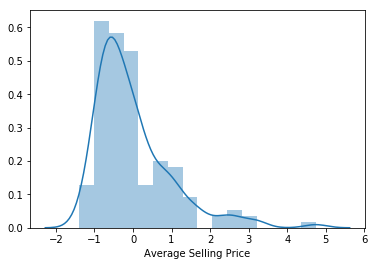

In [41]:
import seaborn as sns
sns.distplot(final_dataframe_std['Average Selling Price'])

Text(0.5, 1.0, 'Price vs Number of schools')

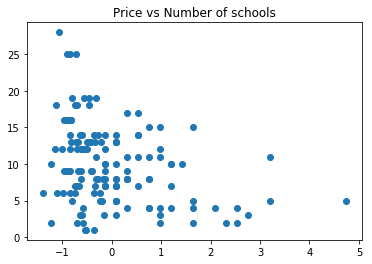

In [43]:
plt.scatter(final_dataframe_std['Average Selling Price'],final_dataframe_std['Number of Schools'])
plt.title("Price vs Number of schools")

<h3 align=Center>Data Modelling</h3>

In [32]:
# Using LinearRegression, we can get the list of coefficient correlations between each type of venue and the average price
lreg = LinearRegression(normalize=True)

X = final_dataframe_std.drop(columns=['Neighborhood', 'Postalcode','Borough'])
y = final_dataframe_std['Average Selling Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)



In [33]:
y_pred = lreg.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred)) # r2 score
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) # mse


R2-score: 0.9564427355653444
Mean Squared Error: 0.03681781610384425


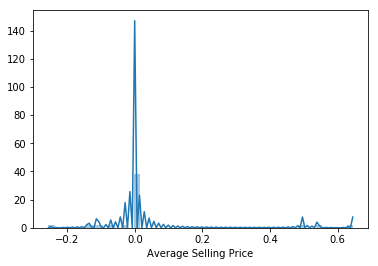

In [34]:
sns.distplot((y_test-y_pred))

In [35]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))

MAE: 0.08240852247412929
MSE: 0.03681781610384425


Text(0.5, 1.0, 'Linear Regression Model')

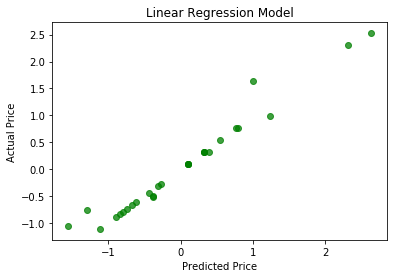

In [36]:
import matplotlib.pyplot as plt 
actual_values = y_test
plt.scatter(y_pred, actual_values, alpha=.75,
            color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

In [37]:
from sklearn import ensemble
lr = ensemble.GradientBoostingRegressor()
model = lr.fit(X_train, y_train)
print ("R^2 is: \n", model.score(X_test, y_test))

R^2 is: 
 0.9970981042986711


In [38]:
y_pred_gbr = lr.predict(X_test)

In [39]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_gbr))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_gbr))

MAE: 0.0167844879815183
MSE: 0.002452896518429147


Text(0.5, 1.0, 'GBR Model')

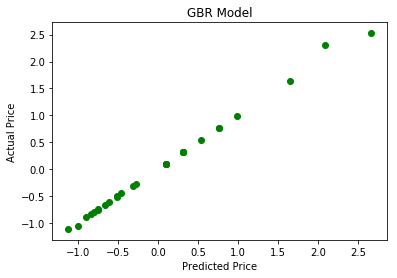

In [40]:
actual_values = y_test
plt.scatter(y_pred_gbr, actual_values,
            color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('GBR Model')

<h5>Conclusion:
The results seem to suggest that there may be overfitting. We focused our efforts on finding out if the number of schools and venues present in the vicinity affects the price of a property. As natural next step, we would like to gather more data on the quality and rankings of these schools and built a model to predict prices.</h5>
